In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import time
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [17]:
from funcshape.testlib.surfaces import HyperbolicParaboloid, RotationDiffeomorphism

from funcshape.surface import ComposedSurface
from funcshape.transforms import Qmap2D, SRNF
from funcshape.visual import (
    get_common_colornorm,
    plot_surface,
    plot_diffeomorphism_2d,
    save_surface_reparam,
    save_diffeomorphism_2d,
    save_error_plot
)
    

from funcshape.networks import SurfaceReparametrizer
from funcshape.layers.sinefourier import SineFourierLayer
from funcshape.loss import SurfaceDistance
from funcshape.reparametrize import reparametrize
from funcshape.logging import Logger

## Example 1: SRNF

[Iter     1] loss: 0.165807
[Iter     2] loss: 0.097382
[Iter     3] loss: 0.017297
[Iter     4] loss: 0.006108
[Iter     5] loss: 0.002679
[Iter     6] loss: 0.001754
[Iter     7] loss: 0.001562
[Iter     8] loss: 0.001317
[Iter     9] loss: 0.001261
[Iter    10] loss: 0.001035
[Iter    11] loss: 0.000961
[Iter    12] loss: 0.000905
[Iter    13] loss: 0.000871
[Iter    14] loss: 0.000815
[Iter    15] loss: 0.000777
[Iter    16] loss: 0.000723
[Iter    17] loss: 0.000690
[Iter    18] loss: 0.000661
[Iter    19] loss: 0.000620
[Iter    20] loss: 0.000559
[Iter    21] loss: 0.000524
[Iter    22] loss: 0.000483
[Iter    23] loss: 0.000455
[Iter    24] loss: 0.000417
[Iter    25] loss: 0.000412
[Iter    26] loss: 0.000355
[Iter    27] loss: 0.000344
[Iter    28] loss: 0.000329
[Iter    29] loss: 0.000307
[Iter    30] loss: 0.000279
[Iter    31] loss: 0.000255

Finished training in 9.83419s


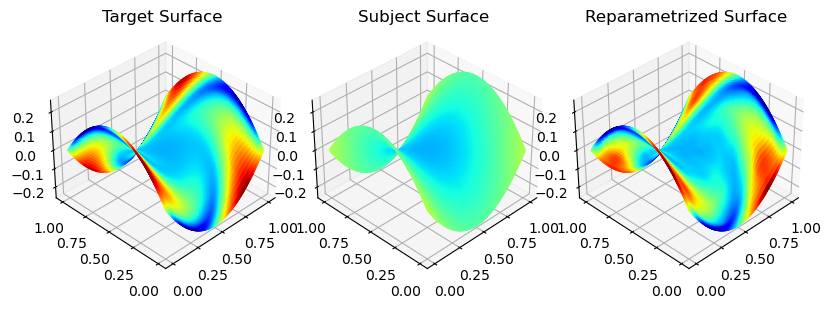

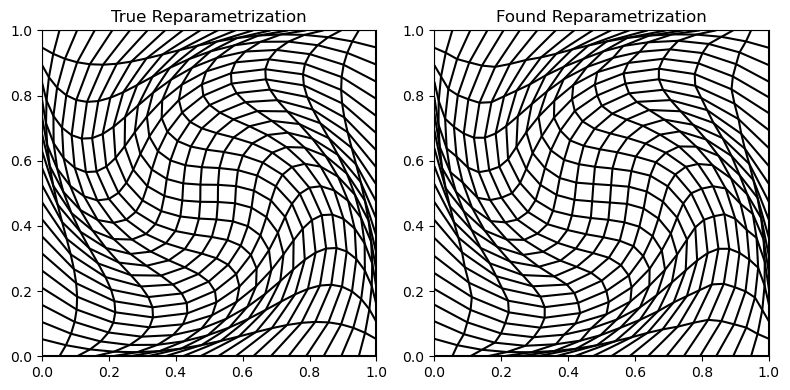

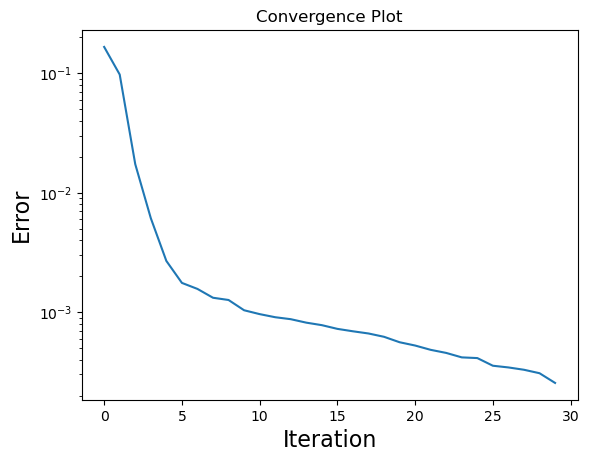

In [20]:
f = HyperbolicParaboloid()
γ = RotationDiffeomorphism()
g = f.compose(γ)
g = ComposedSurface(f, γ)
q = SRNF(g)
r = SRNF(f)

# Use GPU capabilities? Makes small differences for small networks,
# but is significantly more scalable.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineFourierLayer(10) for _ in range(10)]
).to(device)
loss_func = SurfaceDistance(q, r, k=32, h=1e-4).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=30, line_search_fn="strong_wolfe")
errors = reparametrize(RN, loss_func, optimizer, 1, Logger(1))
RN.to("cpu"), loss_func.to("cpu"); # Need on CPU for plotting.
RN.detach()

# Reparametrize f
fafter = f.compose(RN)

# Define figure path for saving
path = "../figures/surface-reparametrization-srnf"

# Create Coloring Functions for plotting
k = 100 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g, fafter), k=k)

save_surface_reparam(path, f, g, RN, camera, k)
save_error_plot(path, errors)
save_diffeomorphism_2d(path, γ, RN, k=20, clear=True)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

plot_surface(g, ax=ax1, k=k, colornorm=norm, camera=camera)
ax1.set_title("Target Surface")
plot_surface(f, ax=ax2, k=k, colornorm=norm, camera=camera)
ax2.set_title("Subject Surface")
plot_surface(fafter, ax=ax3, k=k, colornorm=norm, camera=camera)
ax3.set_title("Reparametrized Surface")
plt.tight_layout()
plt.show()

# Plot Diffeomorphisms. 
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
plot_diffeomorphism_2d(γ, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

ax = fig.add_subplot(122)
plot_diffeomorphism_2d(RN, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")
plt.tight_layout()
plt.show()

plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plot")
plt.show()

In [35]:
norm = get_common_colornorm((f, g, fafter), k=k)


In [56]:
import matplotlib

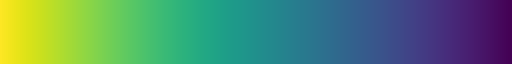

In [60]:
matplotlib.colormaps["viridis_r"]

In [55]:
%matplotlib

TypeError: 'module' object is not subscriptable

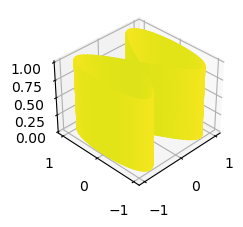

In [65]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
plot_surface(f, ax=ax1, k=k, colornorm=norm, camera=camera, 
             colormap=matplotlib.colormaps["viridis_r"])
plt.savefig("/home/jorgen/mytest.png")
plt.show()

## Example 2: Qmap 

In [7]:
from funcshape.testlib.surfaces import CylinderWrap, LogStepQuadratic

In [27]:
f = CylinderWrap()
γ = RotationDiffeomorphism().compose(LogStepQuadratic())
g = f.compose(γ)
g = ComposedSurface(f, γ)
q = Qmap2D(g)
r = Qmap2D(f)

# Use GPU capabilities? Makes small differences for small networks,
# but is significantly more scalable.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineFourierLayer(20) for _ in range(20)]
).to(device)
loss_func = SurfaceDistance(q, r, k=32, h=1e-4).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=30, line_search_fn="strong_wolfe")
errors = reparametrize(RN, loss_func, optimizer, 1, Logger(1))
RN.to("cpu"), loss_func.to("cpu"); # Need on CPU for plotting.
RN.detach()

# Reparametrize f
fafter = f.compose(RN)

[Iter     1] loss: 13.168871
[Iter     2] loss: 11.848524
[Iter     3] loss: 10.190599
[Iter     4] loss: 7.397508
[Iter     5] loss: 5.784983
[Iter     6] loss: 3.997443
[Iter     7] loss: 3.291536
[Iter     8] loss: 2.558955
[Iter     9] loss: 2.014452
[Iter    10] loss: 1.382008
[Iter    11] loss: 1.147941
[Iter    12] loss: 0.879464
[Iter    13] loss: 0.653835
[Iter    14] loss: 0.456097
[Iter    15] loss: 0.298769
[Iter    16] loss: 0.267307
[Iter    17] loss: 0.227711
[Iter    18] loss: 0.202670
[Iter    19] loss: 0.182302
[Iter    20] loss: 0.142760
[Iter    21] loss: 0.093770
[Iter    22] loss: 0.069583
[Iter    23] loss: 0.053516
[Iter    24] loss: 0.045009
[Iter    25] loss: 0.037333
[Iter    26] loss: 0.027699
[Iter    27] loss: 0.023311
[Iter    28] loss: 0.019828
[Iter    29] loss: 0.018575
[Iter    30] loss: 0.016445
[Iter    31] loss: 0.013322

Finished training in 104.46744s


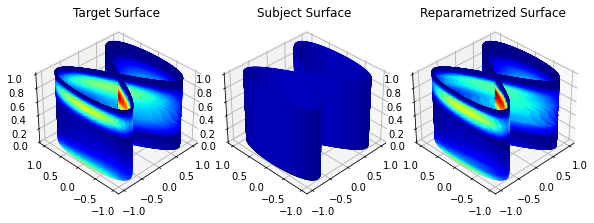

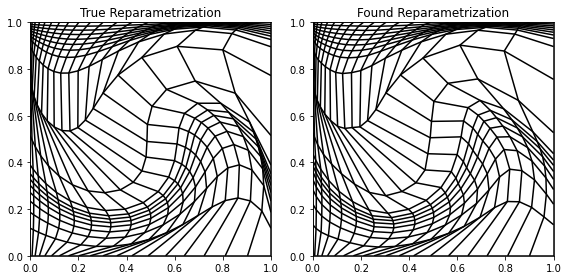

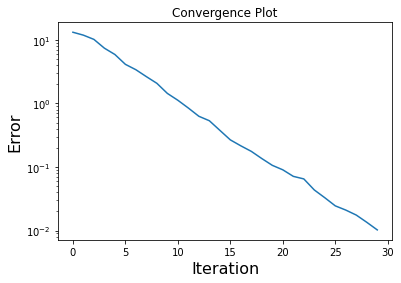

In [12]:
# Define figure path for saving
path = "../figures/surface-reparametrization-qmap"

# Create Coloring Functions for plotting
k = 256 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g, fafter), k=k)

save_surface_reparam(path, f, g, RN, camera, k)
save_error_plot(path, errors)
save_diffeomorphism_2d(path, γ, RN, k=24, clear=True)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
                        
plot_surface(g, ax=ax1, k=k, colornorm=norm, camera=camera)
plot_surface(f, ax=ax2, k=k, colornorm=norm, camera=camera)
plot_surface(fafter, ax=ax3, k=k, colornorm=norm, camera=camera)
ax1.set_title("Target Surface")
ax2.set_title("Subject Surface")
ax3.set_title("Reparametrized Surface")
plt.tight_layout()
plt.show()

# Plot Diffeomorphisms. 
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
plot_diffeomorphism_2d(γ, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

ax = fig.add_subplot(122)
plot_diffeomorphism_2d(RN, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")
plt.tight_layout()
plt.show()

plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plot")
plt.show()